# **Utilizando CNNs para análise gráfica de ações**
O objetivo desse exercício é avaliar se CNNs são capazes de aprender comportamentos ligados a [análise gráfica](https://www.modalmais.com.br/blog/analise-grafica/) (também chamada de análise técnica), utilizados por economistas e profissionais do mercado financeiro para prever variações de curto-prazo em preços de ativos a partir de determinados padrões visuais examinados em gráficos que correlacionam volume e preços negociados.

A análise gráfica é diferente da [análise fundamentalista](https://warren.com.br/magazine/analise-fundamentalista-e-tecnica/), focada em analisar fundamentos financeiros da empresa (crescimento de receita, composição do board, resultados operacionais, etc.) para definir estratégias de investimento de médio e longo-prazo.

Seu principal objetivo é especular com preços no curto-prazo para ganhar com a volatilidade dos mercados. Por isso, é muito utilizada em negociações de day trade ou de ativos com alta volatilidade (ações, crypto, índices, etc.).

In [ ]:
!pip install -q yfinance mplfinance tensorflow scikit-learn Pillow TA-Lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 47.4 MB/s eta 0:00:00


In [ ]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import random as rd
import gc
import shutil
import zipfile
from pathlib import Path
from google.colab import drive

# Bibliotecas financeiras e visuais
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from PIL import Image
import mplfinance as mpf

# Tensorflow e Scikit-Learn
import tensorflow as tf
import keras
from keras import saving
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

# Utils para gerar datasets
Uma vez que a análise técnica é baseada na observação de comportamentos visuais em gráficos, usar CNNs se torna uma opção se elas forem capazes de aprender [os mesmos comportamentos visuais observados por economistas](https://www.warriortrading.com/candlestick-charts/) nessa modalidade.

Para isso, é necessário gerar um dataset com um grande volume de dados de ativos financeiros representados visualmente, utilizando o padrão de [candlestick](https://www.jaspersoft.com/articles/what-is-a-candlestick-chart) comum nesse tipo de análise.

Na célula abaixo, foram construídas quatro funções que realizam esse processo e transformam o resultado em um dataset treinável pelo Keras.

In [ ]:
def download_data(tickers, period='1mo', interval='1d'):
    """
    Baixa dados históricos de ações usando yfinance.

    Args:
        tickers (list ou str): Símbolos dos tickers (ex: ['AAPL', 'MSFT'] ou 'AAPL').
        period (str): Período dos dados (ex: '1mo', '1d', '1y'). Padrão: '1mo'.
        interval (str): Intervalo entre dados (ex: '1m', '5m', '1h', '1d'). Padrão: '1m'.

    Returns:
        pd.DataFrame: Dados OHLCV com colunas em minúsculo e coluna 'ticker'.
                     DataFrame vazio se não houver dados disponíveis.
    """
    print(f"Baixando dados: {tickers}, período={period}, intervalo={interval}")

    # Download em lote é mais eficiente que múltiplas requisições individuais
    downloaded_data = yf.download(tickers, period=period, interval=interval, auto_adjust=True,
                                  group_by='ticker', threads=True, progress=False)

    if downloaded_data.empty:
        print("Aviso: Nenhum dado disponível para download.")
        return pd.DataFrame()

    # Ticker único: estrutura de colunas é diferente (sem MultiIndex)
    if len(tickers) == 1:
        downloaded_data.columns = downloaded_data.columns.str.lower()
        downloaded_data['ticker'] = tickers[0]
        print(f"Download concluído: {len(downloaded_data)} registros para {tickers[0]}")
        return downloaded_data

    # Múltiplos tickers: concatena dados de cada ticker individualmente
    ticker_dataframes = []
    for ticker_symbol in tickers:
        if ticker_symbol not in downloaded_data.columns.get_level_values(0):
            print(f"Aviso: {ticker_symbol} não encontrado nos dados baixados.")
            continue

        ticker_df = downloaded_data[ticker_symbol].copy()
        if ticker_df.empty:
            print(f"Aviso: {ticker_symbol} sem dados disponíveis.")
            continue

        ticker_df.columns = ticker_df.columns.str.lower()
        ticker_df['ticker'] = ticker_symbol
        ticker_dataframes.append(ticker_df)

    result = pd.concat(ticker_dataframes, ignore_index=False) if ticker_dataframes else pd.DataFrame()
    print(f"Download concluído: {len(result)} registros totais para {len(ticker_dataframes)} tickers")
    return result

def generate_samples(stock_data, tickers=None, num_samples=100, sample_size=20,
                     horizon='next5', output_directory='/content/samples', batch_size=10):
    """
    Gera imagens de candlestick para treinamento de modelos de ML.

    Cada imagem contém uma janela temporal de candles e é rotulada com base no
    movimento futuro do preço (up/down) após o horizonte especificado.
    Para cada amostra, gera oito variações com estilos visuais diferentes.

    Args:
        stock_data (pd.DataFrame): Dados com colunas 'ticker', 'open', 'high', 'low', 'close', 'volume'.
        tickers (list, optional): Tickers para gerar amostras. If None, uses all available tickers.
        num_samples (int): Quantidade de amostras por ticker.
        sample_size (int): Número de candles em cada imagem.
        horizon (str): Janela futura para determinar o rótulo. Opções: 'next', 'next5', 'next15', 'next30', 'next60'.
        output_directory (str): Diretório de saída das imagens. Padrão: '/content/samples'.
        batch_size (int): Número de amostras processadas por lote (padrão: 10).

    Returns:
        pd.DataFrame: Metadados com colunas 'filename', 'label_ta' e 'label_calc' ('up' ou 'down').
    """

    def calculate_price_direction(ohlc_values, starting_index, sample_size, price_horizon):
        """
        Calcula a direção do preço baseado em padrões de candlestick TA-Lib,
        prioritizando padrões estritamente direcionais e usando a soma dos
        sinais como desempate.
        """

        # Categorize patterns based on the lists defined here
        bullish_patterns = [
            'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLCONCEALBABYSWALL',
            'CDLHOMINGPIGEON', 'CDLLADDERBOTTOM', 'CDLMATCHINGLOW',
            'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR',
            'CDLPIERCING', 'CDLSTICKSANDWICH', 'CDLUNIQUE3RIVER',
            'CDLHAMMER', 'CDLINVERTEDHAMMER', 'CDLDRAGONFLYDOJI', 'CDLGRAVESTONEDOJI'
        ]

        bearish_patterns = [
            'CDL2CROWS', 'CDL3BLACKCROWS', 'CDLADVANCEBLOCK',
            'CDLDARKCLOUDCOVER', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR',
            'CDLIDENTICAL3CROWS', 'CDLINNECK', 'CDLONNECK',
            'CDLSTALLEDPATTERN', 'CDLTHRUSTING', 'CDLUPSIDEGAP2CROWS',
            'CDLSHOOTINGSTAR', 'CDLHANGINGMAN'
        ]

        both_patterns = [
            'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE',
            'CDLABANDONEDBABY', 'CDLBREAKAWAY', 'CDLCOUNTERATTACK',
            'CDLDOJISTAR', 'CDLENGULFING', 'CDLGAPSIDESIDEWHITE',
            'CDLHARAMI', 'CDLHARAMICROSS', 'CDLHIKKAKE',
            'CDLHIKKAKEMOD', 'CDLKICKING', 'CDLKICKINGBYLENGTH',
            'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLTASUKIGAP',
            'CDLTRISTAR', 'CDLXSIDEGAP3METHODS'
        ]


        end_idx = starting_index + sample_size
        # Analyze only the last 35% of the sample for pattern detection
        analysis_start_in_sample = max(0, int(sample_size * 0.65)) # Start index within the sample slice

        sample_data = ohlc_values[starting_index:end_idx]

        # Check if sample_data is empty or not the expected size
        if not sample_data.shape[0] == sample_size:
            return (None, None)

        sample_df = pd.DataFrame(sample_data, columns=ohlc_values.dtype.names)

        # Extract OHLC
        opens = sample_df['open'].values
        highs = sample_df['high'].values
        lows = sample_df['low'].values
        closes = sample_df['close'].values

        # Check if OHLC arrays are empty
        if not opens.size > 0:
             return (None, None)

        # Get all candlestick pattern functions from TA-Lib
        pattern_functions = [f for f in dir(talib) if f.startswith('CDL')]

        strictly_bullish_found = False
        strictly_bearish_found = False
        overall_pattern_score = 0 # To be used for tie-breaking


        # Analyze patterns within the analysis window (last 35% of sample)
        for pattern_name in pattern_functions:
            try:
                result = getattr(talib, pattern_name)(opens, highs, lows, closes)

                # Check for non-zero signals within the analysis window
                analysis_window_results = result[analysis_start_in_sample:]
                if np.any(analysis_window_results != 0):
                    # Check if the pattern is strictly bullish or bearish
                    if pattern_name in bullish_patterns:
                        strictly_bullish_found = True
                    elif pattern_name in bearish_patterns:
                        strictly_bearish_found = True

                    # Add the sum of non-zero results from the analysis window to the overall score
                    overall_pattern_score += np.sum(analysis_window_results)


            except Exception as e:
                 # Catch potential errors with specific patterns or data
                 # print(f"Warning: Could not analyze pattern {pattern_name}: {e}")
                 pass # Ignore patterns that might fail for specific data


        # Determine TA-lib direction based on the specified logic
        talib_direction = 'neutral'

        if strictly_bullish_found and not strictly_bearish_found:
            talib_direction = 'up'
        elif strictly_bearish_found and not strictly_bullish_found:
            talib_direction = 'down'
        elif strictly_bullish_found and strictly_bearish_found:
            # Tie-breaker: if both strictly bullish and bearish patterns found, use overall score
            if overall_pattern_score > 0:
                talib_direction = 'up'
            elif overall_pattern_score < 0:
                talib_direction = 'down'
            else:
                talib_direction = 'neutral' # If scores are equal
        # If neither strictly bullish nor strictly bearish patterns found,
        # the talib_direction remains 'neutral' as initialized, unless 'both' patterns
        # contributed to the overall_pattern_score in a significant way (which
        # is handled by the tie-breaker logic if strictly patterns were also present).
        # If only 'both' patterns were present, the score determines the direction.
        elif not strictly_bullish_found and not strictly_bearish_found:
             if overall_pattern_score > 0:
                 talib_direction = 'up'
             elif overall_pattern_score < 0:
                 talib_direction = 'down'
             else:
                 talib_direction = 'neutral'


        # Determine actual direction based on price movement
        # Ensure future_idx is within the bounds of ohlc_values
        future_idx = end_idx + price_horizon
        actual_direction = None
        if future_idx < len(ohlc_values) and closes.size > 0:
            last_close = closes[-1]
            future_close = ohlc_values[future_idx]['close']
            actual_direction = 'up' if future_close > last_close else 'down'
        elif closes.size > 0:
             # If future data is not available, but sample data is, use neutral as a fallback
             actual_direction = 'neutral'


        return (talib_direction, actual_direction)

    def normalize_sample(sample_candles, columns_to_normalize, column_rename_mapping):
        """Normaliza as colunas e renomeia para formato esperado pelo mplfinance."""
        sample_normalized = sample_candles.copy()
        for column_name in columns_to_normalize:
            column_min = sample_normalized[column_name].min()
            column_max = sample_normalized[column_name].max()
            if column_max != column_min and column_max != 0 and column_min != 0 and column_max is not None and column_min is not None:
                sample_normalized[column_name] = (sample_normalized[column_name] - column_min) / (column_max - column_min)
            else:
                sample_normalized[column_name] = 0
        sample_normalized.rename(columns=column_rename_mapping, inplace=True)
        return sample_normalized

    def generate_image_variations(sample_candles, ticker_symbol, images_generated, chart_styles,
                                  output_path, label_ta, label_calc, image_metadata):
        """Gera oito variações de imagem com estilos diferentes."""
        style_indices = rd.sample(range(len(chart_styles)), 8)

        for variation in range(1, 9):
            image_filename = f"{ticker_symbol}_sample_{images_generated + 1}_{variation}.png"
            image_full_path = output_path / image_filename

            selected_style = chart_styles[style_indices[variation - 1]]

            volume = rd.choice([True, False])

            plot_kwargs = dict(
                data=sample_candles,
                type='candle',
                style=selected_style,
                volume=volume,
                figratio=(1, 1),
                figsize=(3, 3),
                returnfig=True
            )

            chart_figure, chart_axes = mpf.plot(**plot_kwargs)

            # Remove eixos para focar apenas nos padrões visuais
            for axis in chart_axes:
                ymin, ymax = axis.get_ylim()
                if ymin == ymax:
                  axis.set_ylim(ymin - 0.5, ymax + 0.5)
                axis.set_yticks([])
                axis.set_xticks([])
                axis.set_ylabel("")

            chart_figure.savefig(image_full_path, dpi=100, bbox_inches='tight')
            plt.close(chart_figure)

            del chart_figure, chart_axes
            image_metadata.append({
                'filename': str(image_full_path.resolve()),
                'label_ta': label_ta,
                'label_calc': label_calc
            })

    def process_batch(batch_indices, ticker_data_memmap, ticker_symbol, images_generated_start,
                      chart_styles, output_path, columns_to_normalize, column_rename_mapping,
                      price_horizon, sample_size, ohlc_memmap):
        """Processa um lote de amostras."""
        batch_metadata = []
        images_generated = images_generated_start

        for starting_index in batch_indices:
            # Extrai amostra do memmap
            sample_data = ticker_data_memmap[starting_index:starting_index + sample_size]

            if not sample_data.shape[0] == sample_size:
                 print(f"  Aviso: Sample data has incorrect size ({sample_data.shape[0]} instead of {sample_size}) - skipping sample at index {starting_index}")
                 continue

            sample_candles = pd.DataFrame(sample_data, columns=ticker_data_memmap.dtype.names)


            # Cria DatetimeIndex para mplfinance
            sample_candles.index = pd.date_range(start='2020-01-01', periods=len(sample_candles), freq='D')

            if len(sample_candles) != sample_size or sample_candles.isnull().any().any():
                print(f"  Aviso: Sample data is null or has incorrect size ({len(sample_candles)}) - skipping sample at index {starting_index}")
                continue

            # Calcula direção do preço usando memmap - retorna tupla (label_ta, label_calc)
            direction_tuple = calculate_price_direction(ohlc_memmap, starting_index, sample_size, price_horizon)
            if direction_tuple[0] is None or direction_tuple[1] is None:
                # print(f"  Aviso: Could not calculate price direction for sample at index {starting_index} - skipping sample")
                continue # Skip samples where direction cannot be calculated


            label_ta, label_calc = direction_tuple

            # Normalize sample only if label_calc is not None (meaning future data was available)
            if label_calc is not None:
                # Normaliza amostra
                sample_candles = normalize_sample(sample_candles, columns_to_normalize, column_rename_mapping)
            else:
                # If future data is not available, we still generate the image but use neutral label
                label_calc = 'neutral'
                # Normaliza amostra
                sample_candles = normalize_sample(sample_candles, columns_to_normalize, column_rename_mapping)


            # Gera variações
            try:
                generate_image_variations(sample_candles, ticker_symbol, images_generated, chart_styles,
                                          output_path, label_ta, label_calc, batch_metadata)

                del sample_candles
                images_generated += 1

            except Exception as error:
                print(f"  Erro ao gerar imagem {images_generated + 1}: {error}")
                continue

        gc.collect()
        return batch_metadata, images_generated - images_generated_start

    # Converte prediction_horizon string para inteiro
    horizon_mapping = {
        'next': 1,
        'next5': 5,
        'next15': 15,
        'next30': 30,
        'next60': 60
    }
    price_horizon = horizon_mapping.get(horizon, 5)

    # Processamento sequencial (sem paralelização) minimiza uso de memória
    # pois evita duplicação de dados entre processos

    # Infere tickers if not provided
    if tickers is None:
        tickers = stock_data['ticker'].unique().tolist()

    print(f"\nGerando imagens: {num_samples} amostras/ticker (8 variações cada), {sample_size} períodos/amostra")
    print(f"Horizonte de previsão: {horizon} (t+{price_horizon})")

    image_metadata = []
    output_path = Path(output_directory)
    output_path.mkdir(parents=True, exist_ok=True)

    # Available visual styles to diversify the dataset
    chart_styles = ['binance', 'binancedark', 'blueskies', 'brasil', 'charles', 'checkers', 'classic', 'default',
                    'ibd', 'kenan', 'mike', 'nightclouds', 'sas', 'starsandstripes', 'tradingview', 'yahoo']

    columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']
    column_rename_mapping = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}

    for ticker_symbol in tickers:
        print(f"\nProcessando {ticker_symbol}...")
        ticker_data = stock_data[stock_data['ticker'] == ticker_symbol].copy()

        # Remove invalid values
        ticker_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        ticker_data.dropna(inplace=True)

        if ticker_data.empty:
            print(f"  {ticker_symbol}: Sem dados após limpeza - pulando ticker")
            continue

        # Calculate maximum valid index
        max_starting_index = len(ticker_data) - sample_size - price_horizon + 1
        if max_starting_index <= 0:
            print(f"  {ticker_symbol}: Dados insuficientes ({len(ticker_data)} registros) - pulando ticker")
            continue

        # Create memmap for ticker data (saves RAM)
        temp_memmap_path = output_path / f"temp_{ticker_symbol}.dat"
        ticker_data_array = ticker_data[['open', 'high', 'low', 'close', 'volume']].to_records(index=False)
        ticker_data_memmap = np.memmap(temp_memmap_path, dtype=ticker_data_array.dtype,
                                       mode='w+', shape=ticker_data_array.shape)
        ticker_data_memmap[:] = ticker_data_array[:]
        ticker_data_memmap.flush()

        # Memmap for OHLC values (for calculate_price_direction)
        ohlc_memmap = ticker_data_memmap

        # Shuffle indices
        available_indices = list(range(max_starting_index))
        rd.shuffle(available_indices)

        max_unique_samples = len(available_indices)
        unique_samples_count = min(num_samples, max_unique_samples)

        # First pass: generate unique samples in batches
        used_indices = []
        images_generated = 0

        # Divide indices into batches
        first_pass_indices = available_indices[:unique_samples_count]
        batches = [first_pass_indices[i:i + batch_size] for i in range(0, len(first_pass_indices), batch_size)]

        for batch in batches:
            batch_metadata, batch_count = process_batch(
                batch, ticker_data_memmap, ticker_symbol, images_generated,
                chart_styles, output_path, columns_to_normalize, column_rename_mapping,
                price_horizon, sample_size, ohlc_memmap
            )
            image_metadata.extend(batch_metadata)
            images_generated += batch_count
            used_indices.extend(batch)

            # Force garbage collection after each batch
            gc.collect()

        # Second pass: repeat samples if necessary
        if images_generated < num_samples and len(used_indices) > 0:
            repeat_needed = num_samples - images_generated
            print(f"  Gerando {repeat_needed} amostras repetidas para atingir meta de {num_samples}")

            repeat_indices = [used_indices[rd.randint(0, len(used_indices) - 1)]
                              for _ in range(repeat_needed)]
            repeat_batches = [repeat_indices[i:i + batch_size] for i in range(0, len(repeat_indices), batch_size)]

            for batch in repeat_batches:
                batch_metadata, batch_count = process_batch(
                    batch, ticker_data_memmap, ticker_symbol, images_generated,
                    chart_styles, output_path, columns_to_normalize, column_rename_mapping,
                    price_horizon, sample_size, ohlc_memmap
                )
                image_metadata.extend(batch_metadata)
                images_generated += batch_count
                gc.collect()

        print(f"  {ticker_symbol}: {images_generated} amostras geradas (8 variações cada = {images_generated * 8} imagens)")

        # Clean up memmap and temporary file
        del ticker_data_memmap, ohlc_memmap
        temp_memmap_path.unlink(missing_ok=True)
        del ticker_data
        gc.collect()


    print(f"\nGeração concluída: {len(image_metadata)} imagens totais. Exemplos aleatórios abaixo:")

    # Mostra quatro amostras aleatórias
    if len(image_metadata) >= 4:
        sample_indices = rd.sample(range(len(image_metadata)), 4)
        fig, axes = plt.subplots(2, 2, figsize=(6, 6), facecolor="white")

        for idx, ax_idx in enumerate(sample_indices):
            row, col = idx // 2, idx % 2
            img_path = image_metadata[ax_idx]['filename']
            img = Image.open(img_path)
            axes[row, col].imshow(img)
            axes[row, col].set_title(f"TA: {image_metadata[ax_idx]['label_ta']}, Calc: {image_metadata[ax_idx]['label_calc']}", fontsize=10)
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

    return pd.DataFrame(image_metadata)

def merge_samples(dfs, label_column='label', download=False, file_name='dataset'):
    """
    Consolida múltiplos DataFrames de metadados em um único dataset validado.

    Opcionalmente cria um arquivo zip com metadados (CSV) e imagens para download
    no Google Drive, facilitando backup e compartilhamento.

    Args:
        dfs (list): Lista de DataFrames com colunas 'filename' e label.
        label_column (str): Nome da coluna de rótulos. Padrão: 'label'.
        download (bool): Se True, cria zip e salva no Google Drive. Padrão: False.
        file_name (str): Nome do arquivo zip (sem extensão). Padrão: 'dataset'.

    Returns:
        pd.DataFrame: Dataset consolidado e limpo.
    """
    print("\nMesclando metadados...")

    # Remove DataFrames vazios antes de concatenar
    non_empty_dataframes = [df for df in dfs if not df.empty]

    if not non_empty_dataframes:
        print("Erro: Nenhum dado válido para mesclar")
        return pd.DataFrame()

    # Valida presença da coluna de label em todos os DataFrames
    for dataframe_index, dataframe in enumerate(non_empty_dataframes):
        if label_column not in dataframe.columns:
            raise ValueError(f"Coluna '{label_column}' ausente no DataFrame {dataframe_index}.")

    combined_metadata = pd.concat(non_empty_dataframes, ignore_index=True)

    print(f"Total antes da limpeza: {len(combined_metadata)} amostras")

    rows_before_cleaning = len(combined_metadata)

    # Cleaning: remove NaN, infinities, and empty strings
    combined_metadata.dropna(inplace=True)
    combined_metadata.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_metadata.dropna(inplace=True)

    # Remove empty strings or strings with only whitespace
    for column_name in combined_metadata.columns:
        if combined_metadata[column_name].dtype == 'object':
            combined_metadata = combined_metadata[combined_metadata[column_name].str.strip().astype(bool)]

    rows_after_cleaning = len(combined_metadata)
    rows_removed = rows_before_cleaning - rows_after_cleaning

    if rows_removed > 0:
        print(f"Removidas {rows_removed} entradas inválidas")

    print(f"Total após limpeza: {rows_after_cleaning} amostras")

    # Export to Google Drive (Colab environment only)
    if download:
        print("\nPreparando exportação para Google Drive...")

        drive_path = Path('/content/drive')
        if not drive_path.exists() or not drive_path.is_mount():
            print("Erro: Google Drive não montado. Execute: from google.colab import drive; drive.mount('/content/drive')")
            return combined_metadata

        temp_dir = Path('/content/temp_dataset')
        temp_dir.mkdir(parents=True, exist_ok=True)

        # Save metadata as CSV
        metadata_csv_path = temp_dir / 'metadata.csv'
        combined_metadata.to_csv(metadata_csv_path, index=False)

        # Create zip file with CSV and images
        zip_filename = f"{file_name}.zip"
        zip_path = temp_dir / zip_filename

        missing_files = 0
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            zipf.write(metadata_csv_path, arcname='metadata.csv')

            # Add images preserving folder structure
            for _, row in combined_metadata.iterrows():
                filename_with_path = row['filename']
                source_file = Path(filename_with_path)

                if source_file.exists():
                    zipf.write(source_file, arcname=str(source_file))
                else:
                    missing_files += 1

        if missing_files > 0:
            print(f"Aviso: {missing_files} arquivos não encontrados")

        zip_size_mb = zip_path.stat().st_size / (1024 * 1024)
        print(f"Zip criado: {zip_size_mb:.2f} MB")

        # Move to Google Drive
        drive_destination = Path('/content/drive/MyDrive') / zip_filename
        shutil.move(str(zip_path), str(drive_destination))

        print(f"Dataset salvo: {drive_destination}")

        shutil.rmtree(temp_dir)

    return combined_metadata

def prepare_dataset(df, image_size=(128, 128), test_split=0.2, batch_size=32, label='label'):
    """
    Prepara datasets de treino e teste usando ImageDataGenerator do Keras.

    Args:
        df (pd.DataFrame): DataFrame com colunas 'filename' e 'label'.
        image_size (tuple): Tamanho de redimensionamento (altura, largura). Padrão: (128, 128).
        test_split (float): Proporção do teste (0.0 a 1.0). Padrão: 0.2.
        batch_size (int): Tamanho do lote para processamento. Padrão: 32.

    Returns:
        tuple: (train_generator, test_generator, label_encoder)
            - train_generator/test_generator: Generators do Keras
            - label_encoder: LabelEncoder para decodificar predições
    """
    print(f"\nPreparando datasets: divisão treino/teste = {1-test_split:.0%}/{test_split:.0%}")

    # Encode labels
    label_encoder = LabelEncoder()
    df['encoded_label'] = label_encoder.fit_transform(df[label])

    print(f"Codificação dos labels: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

    # Stratified split
    train_df, test_df = train_test_split(
        df,
        test_size=test_split,
        stratify=df['encoded_label'],
        random_state=42
    )

    print(f"Divisão: {len(train_df)} treino, {len(test_df)} teste")

    # Normalization for training and testing
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators from DataFrame
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col=label,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=True
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filename',
        y_col=label,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )

    print(f"\nDatasets preparados com {len(train_generator.class_indices)} classes")
    print(f"  Treino: {len(train_df)} imagens")
    print(f"  Teste: {len(test_df)} imagens")

    return train_generator, test_generator, label_encoder

# Gerando datasets
Utilizando as funções criadas acima, nessa seção são gerados datasets que podem ser utilizados para treinamento, validação e teste do modelo.

In [ ]:
## Definindo parâmetros para gerar datasets nas próximas células
tickers = ['TLK', 'VTEX', 'TM', 'KB', 'TSM', 'SHG', 'MUFG', 'SONY', 'KEP', 'PKX', 'WF', 'QQQM', 'HDB', 'KT', 'MFG', 'SKM', 'IBN', 'HMC', 'PAM', 'LPL', 'TAK', 'GGAL', 'INFY', 'NVDA', 'IX', 'MSFT', 'AAPL', 'NMR', 'BABA', 'GOOG', 'WIT', 'AMZN', 'META', 'AVGO', 'LOMA', 'TSLA', 'RDY', 'CHT', 'WMT', 'ORCL', 'AMJB', 'ASX', 'LLY', 'NTES', 'V', 'GFI', 'SUPV', 'SPY', 'UMC', 'AU', 'NFLX', 'MA', 'XOM', 'JNJ', 'PLTR', 'COST', 'IVV', 'JD', 'ABBV', 'PBR', 'NVD', 'HD', 'ITUB', 'TCOM', 'BAC', 'AMD', 'PG', 'ASML', 'BIDU', 'UNH', 'GE', 'CVX', 'ERIC', 'ONC', 'TME', 'KO', 'SAP', 'CSCO', 'VALE', 'WFC', 'VTI', 'TMUS', 'IBM', 'MS', 'PM', 'CAT', 'QQQ', 'GS', 'ABT', 'AXP', 'CRM', 'HMY', 'NVS', 'MCD', 'RTX', 'MRK', 'MU', 'PEP', 'RY', 'TKC', 'DIS', 'APP', 'SHOP', 'TMO', 'UBER', 'AZN', 'BX', 'NVO', 'LI', 'ABEV', 'NOW', 'T', 'BLK', 'C', 'INTU', 'PDD', 'ARM', 'GEV', 'ANET', 'LRCX', 'QCOM', 'NEE', 'AMAT', 'HSBC', 'BKNG', 'VZ', 'SCHW', 'BBD', 'BEKE', 'INTC', 'BA', 'XPEV', 'TJX', 'AMGN', 'TXN', 'ISRG', 'SHEL', 'ACN', 'APH', 'DHR', 'SBSW', 'GILD', 'SPGI', 'ETN', 'BSX', 'SYK', 'PGR', 'ADBE', 'PANW', 'SPOT', 'PFE', 'COF', 'KLAC', 'LOW', 'UNP', 'GLD', 'TD', 'HON', 'IWF', 'SAN', 'NIO', 'MDT', 'CRWD', 'CEG', 'DE', 'VUG', 'EBR', 'HOOD', 'LMT', 'IBKR', 'ZTO', 'ADP', 'ADI', 'DASH', 'TTE', 'CB', 'WELL', 'KKR', 'BN', 'CMCSA', 'COP', 'UL', 'MO', 'SO', 'MELI', 'BHP', 'PLD', 'SE', 'SCCO', 'VRTX', 'SNY', 'VIV', 'BSBR', 'ENB', 'MMC', 'CVS', 'NKE', 'DELL', 'NEM', 'DUK', 'CP', 'HCA', 'MCK', 'CME', 'TT', 'BUD', 'PH', 'BAM', 'RBLX', 'BBVA', 'SBUX', 'HTHT', 'ICE', 'BERZ', 'GD', 'AEM', 'NOC', 'BMY', 'CDNS', 'WM', 'COIN', 'ORLY', 'BILI', 'AMT', 'RIO', 'MCO', 'MSTR', 'VTV', 'SBS', 'RCL', 'SHW', 'RELX', 'SNPS', 'BTI', 'SNOW', 'MMM', 'CI', 'VWO', 'MDLZ', 'EQIX', 'ELV', 'BNS', 'ESLT', 'AJG', 'HWM', 'AON', 'BZ', 'ECL', 'MSI', 'APO', 'ABNB', 'WMB', 'CMRC', 'DHIL', 'CAEP', 'LAW', 'BW', 'AGL', 'MBAV', 'MTW', 'DBVT', 'SVC', 'CNDT', 'WENN', 'AURA', 'VERI', 'GPAT', 'JELD', 'PFL', 'TCI', 'RDAG', 'BRBS', 'GCBC', 'ALF', 'SVCC', 'USNA', 'GIG', 'SMLR', 'HDSN', 'HIX', 'CEPT', 'BMRC', 'AMBC', 'TMCI', 'NCMI', 'BSRR', 'MYN', 'DDL', 'LEO', 'THH', 'MLAB', 'RM', 'ESEA', 'SGU', 'TTGT', 'SRDX', 'FRBA', 'CTGO', 'DDD', 'NPAC', 'CHCT', 'VKI', 'BNTC', 'TACO', 'OBE', 'CCIX', 'DCTH', 'EGY', 'CWBC', 'AMRN', 'ATEX', 'ACWV', 'PSBD', 'RPAY', 'VSTA', 'DFDV', 'MVF', 'EAD', 'EHAB', 'TWFG', 'XRX', 'GRRR', 'AONCW', 'LCTX', 'DVLT', 'GRVY', 'FPH', 'EOLS', 'GBLI', 'CIVB', 'SATL', 'MVIS', 'OTLY', 'RMNI', 'RAPT', 'LWAY', 'DPRO', 'IHRT', 'BNC', 'MITK', 'SDHY', 'ELVA', 'CYH', 'MUA', 'GBAB', 'NOA', 'VHI', 'PKE', 'IAT', 'HYLN', 'FBIZ', 'GNE', 'COFS', 'CTRA', 'HNST', 'GMRE', 'ASTL', 'BCAR', 'TRC', 'MSB', 'PBL', 'WEST', 'HBCP', 'CCRN', 'HITI', 'VOXR', 'SD', 'BSVN', 'MCS', 'FFA', 'DIN', 'KRRO', 'AUTL', 'SPIR', 'SOHU', 'DH', 'PDYN', 'SBC', 'EDN', 'ACB', 'PNNT', 'JOUT', 'SB', 'QSI', 'NMAI', 'GLRE', 'NLOP', 'BOC', 'KELYA', 'CAL', 'CMCO', 'ETB', 'DDI', 'EVN', 'PERI', 'VPG', 'WOW', 'IMMP', 'RRBI', 'GRIN', 'BFK', 'DFP', 'NNDM', 'KIDS', 'KRNY', 'EPSM', 'YORW', 'CARE', 'OPAL', 'ASC', 'IMXI', 'ETO', 'CVGW', 'AROW', 'NATH', 'XOMA', 'SWBI', 'GDEV', 'GLAD', 'MAMA', 'EBF', 'OLP', 'ENGN', 'NQP', 'SITC', 'FPI', 'FRA', 'ARKO', 'SPPP', 'CDZI', 'KFS', 'CBLL', 'PLG', 'CGEM', 'LXEO', 'NP', 'BAND', 'IYC', 'IGD', 'HPI', 'WEED', 'RCKT', 'PKST', 'PTLO', 'ADCT', 'NML', 'EQV', 'LPTH', 'FDMT', 'CYRX', 'AII', 'FFIC', 'ACNB', 'HQL', 'PACK', 'GTEN', 'GLDG', 'FULC', 'ANGO', 'MLR', 'BWMX', 'UMAC', 'RMR', 'FRPH', 'LE', 'IXP', 'ZKH', 'NFBK', 'EXI', 'NRIM', 'NGNE', 'FTK', 'EVAC', 'SRTA', 'ANSC', 'LZM', 'VREX', 'HELE', 'PACB', 'INVZ', 'PFIS', 'TWI', 'FFWM', 'IVR', 'NBB', 'ALMS', 'LZMH', 'NPFD', 'NET', 'TEVA', 'CTAS', 'BK', 'VGT']
num_samples = 80
sample_size = 15

Baixando dados: ['WFC', 'RMR', 'ESEA', 'XPEV', 'MLR', 'PNNT', 'BFK', 'DH', 'ETN', 'GNE', 'AMGN', 'SNPS', 'BHP', 'WOW', 'DHIL', 'CCRN', 'ITUB', 'VTI', 'TME', 'SBS', 'AMZN', 'ACB', 'ACWV', 'UNP', 'LRCX'], período=5d, intervalo=1m
Download concluído: 48750 registros totais para 25 tickers

Gerando imagens: 80 amostras/ticker (8 variações cada), 15 períodos/amostra
Horizonte de previsão: next5 (t+5)

Processando WFC...
  WFC: 80 amostras geradas (8 variações cada = 640 imagens)

Processando RMR...


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high yl

  RMR: 80 amostras geradas (8 variações cada = 640 imagens)

Processando ESEA...


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high yl

  ESEA: 80 amostras geradas (8 variações cada = 640 imagens)

Processando XPEV...
  XPEV: 80 amostras geradas (8 variações cada = 640 imagens)

Processando MLR...
  MLR: 80 amostras geradas (8 variações cada = 640 imagens)

Processando PNNT...


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


  PNNT: 80 amostras geradas (8 variações cada = 640 imagens)

Processando BFK...


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high yl

  BFK: 80 amostras geradas (8 variações cada = 640 imagens)

Processando DH...
  DH: 80 amostras geradas (8 variações cada = 640 imagens)

Processando ETN...
  ETN: 80 amostras geradas (8 variações cada = 640 imagens)

Processando GNE...
  GNE: 80 amostras geradas (8 variações cada = 640 imagens)

Processando AMGN...
  AMGN: 80 amostras geradas (8 variações cada = 640 imagens)

Processando SNPS...


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


  SNPS: 80 amostras geradas (8 variações cada = 640 imagens)

Processando BHP...
  BHP: 80 amostras geradas (8 variações cada = 640 imagens)

Processando WOW...
  WOW: 80 amostras geradas (8 variações cada = 640 imagens)

Processando DHIL...
  Gerando 7 amostras repetidas para atingir meta de 80
  DHIL: 80 amostras geradas (8 variações cada = 640 imagens)

Processando CCRN...


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high yl

  CCRN: 80 amostras geradas (8 variações cada = 640 imagens)

Processando ITUB...
  ITUB: 80 amostras geradas (8 variações cada = 640 imagens)

Processando VTI...
  VTI: 80 amostras geradas (8 variações cada = 640 imagens)

Processando TME...
  TME: 80 amostras geradas (8 variações cada = 640 imagens)

Processando SBS...
  SBS: 80 amostras geradas (8 variações cada = 640 imagens)

Processando AMZN...


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high yl

  AMZN: 80 amostras geradas (8 variações cada = 640 imagens)

Processando ACB...


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high yl

  ACB: 80 amostras geradas (8 variações cada = 640 imagens)

Processando ACWV...


/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)
/usr/local/lib/python3.12/dist-packages/mplfinance/plotting.py:707: UserWarning: Attempting to set identical low and high yl

  ACWV: 80 amostras geradas (8 variações cada = 640 imagens)

Processando UNP...
  UNP: 80 amostras geradas (8 variações cada = 640 imagens)

Processando LRCX...
  LRCX: 80 amostras geradas (8 variações cada = 640 imagens)

Geração concluída: 16000 imagens totais. Exemplos aleatórios abaixo:


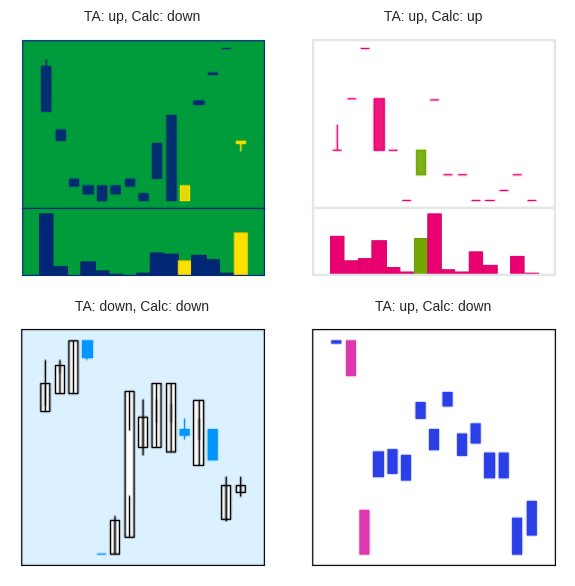

In [ ]:
## Gerando dataset inicial com 25 ações, 80 amostras por ação e 8 gráficos por amostra = 16.000 gráficos
# Utilizando intervalos de 1min, em um período de 5d, com t+5 como horizonte (6min após o final da amostra)
tickers_1 = rd.sample(tickers, 25)
period = '5d'
interval = '1m'
horizon = 'next5'
directory='/content/samples_1'

stocks_1 = download_data(tickers_1, period=period, interval=interval)
samples_1 = generate_samples(stocks_1, num_samples=num_samples, sample_size=sample_size, horizon=horizon, output_directory=directory)

In [ ]:
## Se for necessário/desejado, é possível gerar mais datasets para outros intervalos para adicionar variabilidade nos dados
## Ao executar essa célula, são adicionados mais 48.000 gráficos ao dataset, totalizando 64.000 gráficos
# Samples 2: Utilizando intervalos de 15min, em um período de 5d, com t+5 como horizonte (75min após o final da amostra)
tickers_2 = rd.sample(tickers, 25)
period = '5d'
interval = '15m'
horizon = 'next5'
directory='/content/samples_2'
stocks_2 = download_data(tickers_2, period=period, interval=interval)
samples_2 = generate_samples(stocks_2, num_samples=num_samples, sample_size=sample_size, horizon=horizon, output_directory=directory)

# Samples 3: Utilizando intervalos de 1d, em um período de 2y, com t+5 como horizonte (6d após o final da amostra)
tickers_3 = rd.sample(tickers, 25)
period = '2y'
interval = '1d'
horizon = 'next5'
directory='/content/samples_3'
stocks_3 = download_data(tickers_3, period=period, interval=interval)
samples_3 = generate_samples(stocks_3, num_samples=num_samples, sample_size=sample_size, horizon=horizon, output_directory=directory)

# Samples 4: Utilizando intervalos de 1 semana, em um período de 5y, com t+5 como horizonte (6 semanas após o final da amostra)
tickers_4 = rd.sample(tickers, 25)
period = '5y'
interval = '1wk'
horizon = 'next5'
directory='/content/samples_4'
stocks_4 = download_data(tickers_4, period=period, interval=interval)
samples_4 = generate_samples(stocks_4, num_samples=num_samples, sample_size=sample_size, horizon=horizon, output_directory=directory)

In [ ]:
## Combinando samples gerados em um único dataframe
# Se quiser salvar um arquivo zip com dados no Drive, descomentar linha abaixo e mudar parâmetro `download` para `True`
# drive.mount('/content/drive')

merged_samples = merge_samples([samples_1, samples_2, samples_3, samples_4], download=False)

In [ ]:
## Gerando datasets de treinamento e teste utilizando ImageDataGenerators para melhorar o consumo de memória
# X_train, y_train, X_test, y_test = prepare_dataset(merged_samples, image_size=(128, 128), test_split=0.2)
train_generator, test_generator, label_encoder = prepare_dataset(merged_samples, image_size=(128, 128), test_split=0.2, batch_size=32)

# Arquitetura e treinamento da rede
Nesta seção, é definida a arquitetura da rede neural, bem como é realizado o seu treinamento com base nos datasets gerados na seção anterior. A arquitetura dessa rede é inspirada na arquitetura da LeNet-5, mas com algumas otimizações mais modernas, a exemplo do uso da ReLU como função de ativação das camadas convolucionais e da adição de mais um bloco convolucional para aumentar a profundidade da imagem. O dropout é definido como 30% em cada bloco, o filtro tem 3x3px em todas as camadas, e o stride e o padding não foram modificados.

In [ ]:
## Definição da arquitetura da rede utilizada
# A rede foi inspirada na LeNet-5 que vimos em aula, mas adicionei mais blocos convolucionais
def my_lenet(hidd_neu=128, hidd_act='relu', do_freq=0.3):
    inputs = tf.keras.layers.Input(shape=(128,128,3))

    c1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    c1 = tf.keras.layers.BatchNormalization()(c1)
    c1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(c1)
    s2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c1)
    s2 = tf.keras.layers.Dropout(do_freq)(s2)

    c3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(s2)
    c3 = tf.keras.layers.BatchNormalization()(c3)
    c3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(c3)
    s4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c3)
    s4 = tf.keras.layers.Dropout(do_freq)(s4)

    c5 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(s4)
    c5 = tf.keras.layers.BatchNormalization()(c5)
    c5 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(c5)
    s6 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c5)
    s6 = tf.keras.layers.Dropout(do_freq)(s6)

    flat = tf.keras.layers.Flatten()(s6)
    f7 = tf.keras.layers.Dense(256, activation='relu')(flat)
    f7 = tf.keras.layers.BatchNormalization()(f7)
    f7 = tf.keras.layers.Dropout(do_freq)(f7)
    f8 = tf.keras.layers.Dense(128, activation='relu')(f7)
    f8 = tf.keras.layers.BatchNormalization()(f8)
    f8 = tf.keras.layers.Dropout(do_freq)(f8)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(f8)

    return tf.keras.models.Model(inputs, outputs, name='my_lenet')

model = my_lenet()
model.summary()

Model: "my_lenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,711,587 (33.23 MB)

 Trainable params: 8,710,371 (33.23 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
## Compilando e definindo checkpoints do modelo para otimizar treinamento
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
## Treinando o modelo para 100 épocas (usando ImageDataGenerators por conta de memória)
epochs = 100

H = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[model_checkpoint_callback, early_stopping]
)

In [ ]:
## Apresentando resultados do modelo com dados de teste
results = model.evaluate(test_generator, steps=len(test_generator))

print(f"Final Test Loss: {results[0]:.4f}")
print(f"Final Test Accuracy: {results[1]:.4f}")

In [ ]:
## Reaproveitando código de aula para plotar a matriz de confusão
# Prevendo os valores de Y para os Xs de teste
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Criando a matriz de confusão
cm = confusion_matrix(test_generator.labels, y_pred)

# Apresentando a matriz de confusão utilizando a função sugerida
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(2))
display.plot()
plt.show()

In [ ]:
## Reaproveitando código de aula para calcular métricas de qualidade do modelo
# Calculando a acurácia geral
overallAccuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Overall Accuracy: {overallAccuracy}")
print("-----")

for i in range(2):
  # Calculando e apresentando o erro de omissão
  referenceValues = np.sum(cm[i,:])
  correctlyClassified = np.max(cm[i,:])
  omittedValues = referenceValues - correctlyClassified
  omissionError = round(omittedValues / referenceValues*100, 4)
  print(f"Erro de omissão para {i} = {omissionError}%")

  # Calculando e apresentando o erro de comissão
  classifiedValues = np.sum(cm[:,i])
  correctlyClassified_1 = np.max(cm[:,i])
  committedValues = classifiedValues - correctlyClassified
  commissionError = round(committedValues / classifiedValues*100, 4)
  print(f"Erro de comissão para {i} = {commissionError}%")

  print("-----")

# Calculando o F1-Score
f1 = f1_score(test_generator.classes, y_pred)
print(f"F1 Score: {f1}")

In [ ]:
## Reaproveitando código de aula para gerar gráfico da evolução da acurácia e da perda
fig, ax1 = plt.subplots(figsize=(20, 5))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_xticks(np.arange(epochs))
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(H.history["val_accuracy"], '--', label="val_acc", color=color)
ax1.plot(H.history["accuracy"], label="train_acc", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(H.history["val_loss"], '--', label="val_loss", color=color)
ax2.plot(H.history["loss"], label="train_loss",color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
merged_ta = merge_samples([samples_1], label_column='label_ta')
train_generator, test_generator, label_encoder = prepare_dataset(merged_ta, label='label_ta', image_size=(128, 128), test_split=0.2, batch_size=32)


Mesclando metadados...
Total antes da limpeza: 16000 amostras
Total após limpeza: 16000 amostras

Preparando datasets: divisão treino/teste = 80%/20%
Codificação dos labels: {'down': np.int64(0), 'neutral': np.int64(1), 'up': np.int64(2)}
Divisão: 12800 treino, 3200 teste
Found 12800 validated image filenames belonging to 3 classes.
Found 3200 validated image filenames belonging to 3 classes.

Datasets preparados com 3 classes
  Treino: 12800 imagens
  Teste: 3200 imagens


In [ ]:
## Treinando o modelo para 100 épocas (usando ImageDataGenerators por conta de memória)
epochs = 40

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_ta.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

H = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[model_checkpoint_callback, early_stopping]
)

Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5636 - loss: 1.0806
Epoch 1: val_loss improved from inf to 0.68362, saving model to best_model_ta.weights.h5
400/400 ━━━━━━━━━━━━━━━━━━━━ 565s 1s/step - accuracy: 0.5639 - loss: 1.0800 - val_accuracy: 0.7844 - val_loss: 0.6836
Epoch 2/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7600 - loss: 0.6470
Epoch 2: val_loss did not improve from 0.68362
400/400 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.7600 - loss: 0.6470 - val_accuracy: 0.7284 - val_loss: 0.6966
Epoch 3/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7723 - loss: 0.5862
Epoch 3: val_loss improved from 0.68362 to 0.53736, saving model to best_model_ta.weights.h5
400/400 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.7723 - loss: 0.5862 - val_accuracy: 0.7844 - val_loss: 0.5374
Epoch 4/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7848 - loss: 0.5376
Epoch 4: val_loss improved from 0.53736 to 0.51679, saving model to best_model_ta.weight

In [ ]:
drive.mount('/content/drive')
drive_path = Path('/content/drive')
main_dir = Path('/content/')
model_filename = f"best_model_ta.weights.h5"
model_path = main_dir / model_filename
drive_destination = Path('/content/drive/MyDrive') / model_filename
shutil.move(str(model_path), str(drive_destination))
print(f"Dataset salvo: {drive_destination}")

ValueError: mount failed

In [ ]:
## Apresentando resultados do modelo com dados de teste
results = model.evaluate(test_generator, steps=len(test_generator))

print(f"Final Test Loss: {results[0]:.4f}")
print(f"Final Test Accuracy: {results[1]:.4f}")

In [ ]:
## Reaproveitando código de aula para plotar a matriz de confusão
# Prevendo os valores de Y para os Xs de teste
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Criando a matriz de confusão
cm = confusion_matrix(test_generator.labels, y_pred)

# # Apresentando a matriz de confusão utilizando a função sugerida
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(3))
display.plot()
plt.show()

In [ ]:
## Reaproveitando código de aula para calcular métricas de qualidade do modelo
# Calculando a acurácia geral
overallAccuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Overall Accuracy: {overallAccuracy}")
print("-----")

for i in range(2):
  # Calculando e apresentando o erro de omissão
  referenceValues = np.sum(cm[i,:])
  correctlyClassified = np.max(cm[i,:])
  omittedValues = referenceValues - correctlyClassified
  omissionError = round(omittedValues / referenceValues*100, 4)
  print(f"Erro de omissão para {i} = {omissionError}%")

  # Calculando e apresentando o erro de comissão
  classifiedValues = np.sum(cm[:,i])
  correctlyClassified_1 = np.max(cm[:,i])
  committedValues = classifiedValues - correctlyClassified
  commissionError = round(committedValues / classifiedValues*100, 4)
  print(f"Erro de comissão para {i} = {commissionError}%")

  print("-----")

# Calculando o F1-Score
f1 = f1_score(test_generator.classes, y_pred)
print(f"F1 Score: {f1}")

In [ ]:
## Reaproveitando código de aula para gerar gráfico da evolução da acurácia e da perda
fig, ax1 = plt.subplots(figsize=(20, 5))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_xticks(np.arange(epochs))
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(H.history["val_accuracy"], '--', label="val_acc", color=color)
ax1.plot(H.history["accuracy"], label="train_acc", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(H.history["val_loss"], '--', label="val_loss", color=color)
ax2.plot(H.history["loss"], label="train_loss",color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
merged_calc = merge_samples([samples_1], label_column='label_calc')
train_generator, test_generator, label_encoder = prepare_dataset(merged_calc, image_size=(128, 128), test_split=0.2, batch_size=32)

In [ ]:
## Treinando o modelo para 100 épocas (usando ImageDataGenerators por conta de memória)
epochs = 40

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_calc.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

H = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[model_checkpoint_callback, early_stopping]
)

In [ ]:
drive_path = Path('/content/drive')
main_dir = Path('/content/')
model_filename = f"best_model_calc.weights.h5"
model_path = main_dir / model_filename
drive_destination = Path('/content/drive/MyDrive') / model_filename
shutil.move(str(model_path), str(drive_destination))
print(f"Dataset salvo: {drive_destination}")

In [ ]:
## Apresentando resultados do modelo com dados de teste
results = model.evaluate(test_generator, steps=len(test_generator))

print(f"Final Test Loss: {results[0]:.4f}")
print(f"Final Test Accuracy: {results[1]:.4f}")

In [ ]:
## Reaproveitando código de aula para plotar a matriz de confusão
# Prevendo os valores de Y para os Xs de teste
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Criando a matriz de confusão
cm = confusion_matrix(test_generator.labels, y_pred)

# Apresentando a matriz de confusão utilizando a função sugerida
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(3))
display.plot()
plt.show()

In [ ]:
## Reaproveitando código de aula para calcular métricas de qualidade do modelo
# Calculando a acurácia geral
overallAccuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Overall Accuracy: {overallAccuracy}")
print("-----")

for i in range(2):
  # Calculando e apresentando o erro de omissão
  referenceValues = np.sum(cm[i,:])
  correctlyClassified = np.max(cm[i,:])
  omittedValues = referenceValues - correctlyClassified
  omissionError = round(omittedValues / referenceValues*100, 4)
  print(f"Erro de omissão para {i} = {omissionError}%")

  # Calculando e apresentando o erro de comissão
  classifiedValues = np.sum(cm[:,i])
  correctlyClassified_1 = np.max(cm[:,i])
  committedValues = classifiedValues - correctlyClassified
  commissionError = round(committedValues / classifiedValues*100, 4)
  print(f"Erro de comissão para {i} = {commissionError}%")

  print("-----")

# Calculando o F1-Score
f1 = f1_score(test_generator.classes, y_pred)
print(f"F1 Score: {f1}")

In [ ]:
## Reaproveitando código de aula para gerar gráfico da evolução da acurácia e da perda
fig, ax1 = plt.subplots(figsize=(20, 5))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_xticks(np.arange(epochs))
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(H.history["val_accuracy"], '--', label="val_acc", color=color)
ax1.plot(H.history["accuracy"], label="train_acc", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(H.history["val_loss"], '--', label="val_loss", color=color)
ax2.plot(H.history["loss"], label="train_loss",color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()